In [3]:
# Importing tensorflow and fMNIST

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('fMNIST_data', one_hot=True)

Extracting fMNIST_data/train-images-idx3-ubyte.gz
Extracting fMNIST_data/train-labels-idx1-ubyte.gz
Extracting fMNIST_data/t10k-images-idx3-ubyte.gz
Extracting fMNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# Importing necessary packages

import tensorflow as tf
%pylab inline
import scipy.misc
import scipy
sess = tf.InteractiveSession()
import seaborn as sns
from scipy.ndimage.interpolation import zoom
import time
from random import shuffle

Populating the interactive namespace from numpy and matplotlib


/Users/u830238/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
# Including necessary functions

def batch_mod(x,y): # adds balanced dimming random images with None label
  x_1 = np.int(np.round((np.shape(x)[0])*10.5/10.))
  x1 = np.zeros([x_1,np.shape(x)[1]])
  x1[0:np.shape(x)[0],:] = x
  x1[np.shape(x)[0]:,:] = np.random.random([x_1-np.shape(x)[0],1])*np.random.random([x_1-np.shape(x)[0],np.shape(x)[1]])
  y1 = np.zeros([x_1,np.shape(y)[1]+1])
  y1[0:np.shape(x)[0],:-1] = y
  y1[np.shape(x)[0]:,-1] = 1
  return x1, y1

def gaussian_blur(imgd,sigma_max,size_h=40): # uniform distribution between 0 and sigma_max (which is in pixels)
    img_d = 0.*imgd
    for i in range(np.shape(imgd)[0]):
        blur_i = sigma_max*np.random.random(1)[0]
        img_d[i,:] = np.reshape(scipy.ndimage.filters.gaussian_filter(np.reshape(imgd[i,:],[size_h,size_h]),blur_i),[1,size_h*size_h])
    return img_d

def gaussian_blur_exact(imgd,sigma_max,size_h=40):
    img_d = 0.*imgd
    for i in range(np.shape(imgd)[0]):
        blur_i = sigma_max
        img_d[i,:] = np.reshape(scipy.ndimage.filters.gaussian_filter(np.reshape(imgd[i,:],[size_h,size_h]),blur_i),[1,size_h*size_h])
    return img_d

def occlusion_distort_blocks(imgd,level_max,size_h=40): # uniform distribution between 0 and level_max (which is betwen 0 and 1), block knockout
    img_d = 0.*imgd
    for i in range(np.shape(imgd)[0]):
        occlude_i = np.int(np.floor(level_max*size_h*np.random.random(1)[0]))
        x_min = np.int(np.round((size_h-occlude_i)*np.random.random(1)[0]))
        y_min = np.int(np.round((size_h-occlude_i)*np.random.random(1)[0]))
        dum_1 = imgd[i,:].copy()
        dum_1 = np.reshape(dum_1,[size_h,size_h])
        dum_1[x_min:x_min+occlude_i,y_min:y_min+occlude_i] = 0.
        img_d[i,:] = np.reshape(dum_1,[1,size_h*size_h])
    return img_d

def batch_gen_specific(imgd,sigma_max,level_max,size_h=40): # 0.5 occlusion and blur
    img_d = 0.*imgd
    half_size = np.int(round(np.shape(imgd)[0]/2.))
    img_d[0:half_size,:] = gaussian_blur(imgd[0:half_size,:],sigma_max,size_h)
    img_d[half_size:,:] = occlusion_distort_blocks(imgd[half_size:,:],level_max,size_h)
    return img_d

def batch_mod_test(y): # adds None label
  y1 = np.zeros([np.shape(y)[0],np.shape(y)[1]+1])
  y1[:,:-1] = y
  return y1

def gen_random_pattern(n,p_mix,n_add_p): # p_mix blur+occlusion on random images, n_add_p percent of null and full images added
  n_h = np.int(np.round(n*p_mix))
  x = np.random.random([n*(1+2*n_add_p),1])*np.random.random([n*(1+2*n_add_p),784])
  y = np.zeros([n*(1+2*n_add_p),11])
  y[:,-1] = 1
  x[0:n_h,:] = batch_gen_specific(x[0:n_h,:],10,1)
  x[n_h:n_h+np.int(n*n_add_p),:] = np.ones([np.int(n*n_add_p),784])
  x[n_h+np.int(n*n_add_p):n_h+2*np.int(n*n_add_p),:] = 1e-4*np.random.random([np.int(n*n_add_p),784])
  return x,y

def random_pattern_gen(n,size_h=40):
  x = np.random.random([n,size_h*size_h])
  y = np.zeros([n,11])
  y[:,-1] = 1.
  for i in range(np.shape(x)[0]):
    dum0 = np.random.random(1)[0]
    dum1 = zoom(np.reshape(x[i,:],[size_h,size_h]),dum0)
    dum2_x = np.int((size_h-np.ceil(dum0*1.*size_h))*np.random.random(1)[0])
    dum2_y = np.int((size_h-np.ceil(dum0*1.*size_h))*np.random.random(1)[0])
    dum3 = np.zeros([size_h,size_h])
    dum3[dum2_x:dum2_x+np.shape(dum1)[0],dum2_y:dum2_y+np.shape(dum1)[1]] = dum1
    x[i,:] = np.reshape(dum3,[1,size_h*size_h])
  x = batch_gen_specific(x,9,1,size_h)
  return x,y

def random_pattern_gen_cue(n,size_h=40):
  x = np.random.random([n,size_h*size_h])
  y = np.zeros([n,11])
  y[:,-1] = 1.
  y_z_h = np.zeros([n,10])
  y_c_h = np.zeros([n,11])
  y_o_h = np.zeros([n,2])
  for i in range(np.shape(x)[0]):
    dum0 = np.random.random(1)[0]
    dum1 = zoom(np.reshape(x[i,:],[size_h,size_h]),dum0)
    dum2_x = np.int((size_h-np.ceil(dum0*1.*size_h))*np.random.random(1)[0])
    dum2_y = np.int((size_h-np.ceil(dum0*1.*size_h))*np.random.random(1)[0])
    dum3 = np.zeros([size_h,size_h])
    dum3[dum2_x:dum2_x+np.shape(dum1)[0],dum2_y:dum2_y+np.shape(dum1)[1]] = dum1
    x[i,:] = np.reshape(dum3,[1,size_h*size_h])
    y_z_h[i,np.random.randint(10)] = 1.
    y_o_h[i,1] = 1.
    y_c_h[i,-1] = 1.
    y_c_h[i,:] = y_c_h[i,:]*0.99+0.01/11.
  x = batch_gen_specific(x,9,1,size_h)
  return x,y,y_c_h,y_z_h,y_o_h

def gridify(imgd,labd,n,size_h=40): # n determines how many images will fit on the 2x2 grid
    imgd1 = imgd.copy()
    labd1 = labd.copy()
    labd2 = 0.*labd.copy()
    imgd2 = np.zeros([np.shape(imgd1)[0],size_h*size_h])
    size_h = 40
    for i in range(np.shape(imgd1)[0]):
        dum_h = np.zeros([size_h,size_h])
        order_h = np.arange(4)
        shuffle(order_h)
        order_h = order_h[0:n]
        if 0 in order_h:
            ind_h = np.random.randint(np.shape(imgd1)[0])
            dum_h[0:size_h/2,0:size_h/2] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        if 1 in order_h:
            ind_h = np.random.randint(np.shape(imgd1)[0])                         
            dum_h[0:size_h/2,size_h/2:] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        if 2 in order_h:
            ind_h = np.random.randint(np.shape(imgd1)[0])                          
            dum_h[size_h/2:,0:size_h/2] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        if 3 in order_h:
            ind_h = np.random.randint(np.shape(imgd1)[0])                          
            dum_h[size_h/2:,size_h/2:] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        imgd2[i,:] = np.reshape(dum_h,size_h*size_h)
    for i in range(np.shape(imgd1)[0]):
        labdn = np.sum(labd2[i,:]>0)
        if labdn == 0:
          print(labdn)
        labd2[i,:] = labd2[i,:]/labdn
    return imgd2,labd2

def gridify_exact(imgd,labd,n,size_h=40): # n determines how many unique object images will fit on the 2x2 grid
    imgd1 = imgd.copy()
    labd1 = labd.copy()
    labd2 = 0.*labd.copy()
    imgd2 = np.zeros([np.shape(imgd1)[0],size_h*size_h])
    size_h = 40
    for i in range(np.shape(imgd1)[0]):
        dum_h = np.zeros([size_h,size_h])
        order_h = np.arange(4)
        shuffle(order_h)
        order_h = order_h[0:n]
        ord_im = np.zeros([4,1])
        for j in range(4):
            if j == 0:
                ord_im[j,0] = np.random.randint(np.shape(imgd1)[0])
            else:
                dum1_h = ord_im[j-1,0]
                while dum1_h in ord_im[:j,0]:
                    dum1_h = np.random.randint(np.shape(imgd1)[0])
                    for k in range(j):
                        if np.argmax(labd1[np.int(dum1_h),:]) == np.argmax(labd1[np.int(ord_im[k,0]),:]):
                            dum1_h = ord_im[j-1]
                ord_im[j,0] = dum1_h
        #print ord_im
        if 0 in order_h:
            ind_h = np.int(ord_im[0])
            dum_h[0:size_h/2,0:size_h/2] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        if 1 in order_h:
            ind_h = np.int(ord_im[1])                        
            dum_h[0:size_h/2,size_h/2:] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        if 2 in order_h:
            ind_h = np.int(ord_im[2])                         
            dum_h[size_h/2:,0:size_h/2] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        if 3 in order_h:
            ind_h = np.int(ord_im[3])                         
            dum_h[size_h/2:,size_h/2:] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        imgd2[i,:] = np.reshape(dum_h,size_h*size_h)
    for i in range(np.shape(imgd1)[0]):
        labdn = np.sum(labd2[i,:]>0)
        if labdn == 0:
          print(labdn)
        labd2[i,:] = labd2[i,:]/labdn
    return imgd2,labd2

def accuracy_n(y1,y2): # n is no. of observations, y2 is true label
    n_h = np.shape(y1)[0]
    acc = np.zeros([n_h,1])
    for i in range(n_h):
        obj_h = np.sum(y2[i,:]>0)
        if obj_h == 0:
            print(obj_h)
        y2_h = y2[i,:].copy()
        y1_h = y1[i,:].copy()
        obj_ind = y1_h.argsort()[-np.int(obj_h):][::-1]
        y1_h = 0.*y1_h
        y1_h[obj_ind] = 1.
        y2_h[y2_h>0] = 1.
        acc[i,0] = np.sum(np.multiply(y1_h,y2_h))*1./(obj_h*1.)
    acc = np.mean(acc)
    return acc

def gridify_stoc(imgd,labd,n,size_h=40): # n determines how many max images will fit on the 2x2 grid
    imgd1 = imgd.copy()
    labd1 = labd.copy()
    labd2 = 0.*labd.copy()
    imgd2 = np.zeros([np.shape(imgd1)[0],size_h*size_h])
    size_h = 40
    for i in range(np.shape(imgd1)[0]):
        dum_h = np.zeros([size_h,size_h])
        order_h = np.arange(4)
        shuffle(order_h)
        n_h1 = np.random.randint(1,n+1)
        order_h = order_h[0:n_h1]
        if 0 in order_h:
            ind_h = np.random.randint(np.shape(imgd1)[0])
            dum_h[0:size_h/2,0:size_h/2] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        if 1 in order_h:
            ind_h = np.random.randint(np.shape(imgd1)[0])                         
            dum_h[0:size_h/2,size_h/2:] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        if 2 in order_h:
            ind_h = np.random.randint(np.shape(imgd1)[0])                          
            dum_h[size_h/2:,0:size_h/2] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        if 3 in order_h:
            ind_h = np.random.randint(np.shape(imgd1)[0])                          
            dum_h[size_h/2:,size_h/2:] = zoom(np.reshape(imgd1[ind_h,:],[28,28]),size_h*1./(2*1.*28))
            labd2[i,:] = labd2[i,:] + labd1[ind_h,:]
            labd2[labd2 > 0] = 1.
        imgd2[i,:] = np.reshape(dum_h,size_h*size_h)
    for i in range(np.shape(imgd1)[0]):
        labdn = np.sum(labd2[i,:]>0)
        if labdn == 0:
            print(labdn)
        labd2[i,:] = labd2[i,:]/labdn
    return imgd2,labd2

def y_ext_gen_cong(labd):
  y_c_h = 0.*labd.copy()
  y_z_h = np.zeros([np.shape(labd)[0],10])
  yo_h = np.zeros([np.shape(labd)[0],2])
  for i in range(np.shape(labd)[0]): 
    dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
    dum1_h[0,np.random.randint(10)] = 1.
    while np.sum(np.multiply(dum1_h,labd[i,:10])) == 0:
      dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
      dum1_h[0,np.random.randint(10)] = 1.
    y_z_h[i,:] = dum1_h
    y_c_h[i,:10] = dum1_h
    y_c_h[i,:] = y_c_h[i,:]*0.99+0.01/11.
    yo_h[i,0] = 1.
  return y_c_h, y_z_h, yo_h

def y_ext_gen_incong(labd): # labd[0,:] is 11d; 
  y_c_h = 0.*labd.copy()
  y_z_h = np.zeros([np.shape(labd)[0],10])
  yo_h = np.zeros([np.shape(labd)[0],2])
  for i in range(np.shape(labd)[0]): # matching incongruent cue to incongruent question
    dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
    dum1_h[0,np.random.randint(10)] = 1.
    while np.sum(np.multiply(dum1_h,labd[i,:10])) > 0:
      dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
      dum1_h[0,np.random.randint(10)] = 1.
    y_z_h[i,:] = dum1_h
    y_c_h[i,:10] = dum1_h
    y_c_h[i,:] = y_c_h[i,:]*0.99+0.01/11.
    yo_h[i,0] = 1.
  return y_c_h, y_z_h, yo_h

def y_ext_gen_unk(labd):
  y_c_h = 0.*labd.copy()
  y_z_h = np.zeros([np.shape(labd)[0],10])
  yo_h = np.zeros([np.shape(labd)[0],2])
  for i in range(np.shape(labd)[0]): 
    if np.random.random(1)[0] > 1./2.:
      dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
      dum1_h[0,np.random.randint(10)] = 1.
      while np.sum(np.multiply(dum1_h,labd[i,:10])) == 0:
        dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
        dum1_h[0,np.random.randint(10)] = 1.
      y_z_h[i,:] = dum1_h
      y_c_h[i,-1] = 1.
      y_c_h[i,:] = y_c_h[i,:]*0.99+0.01/11.
      yo_h[i,0] = 1.
    else:
      dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
      dum1_h[0,np.random.randint(10)] = 1.
      while np.sum(np.multiply(dum1_h,labd[i,:10])) > 0:
        dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
        dum1_h[0,np.random.randint(10)] = 1.
      y_z_h[i,:] = dum1_h
      y_c_h[i,-1] = 1.
      y_c_h[i,:] = y_c_h[i,:]*0.99+0.01/11.
      yo_h[i,1] = 1.
  return y_c_h, y_z_h, yo_h

def y_ext_gen_neut(labd): # labd[0,:] is 11d;
  y_z_h = np.zeros([np.shape(labd)[0],10])
  yo_h = np.zeros([np.shape(labd)[0],2])
  for i in range(np.shape(labd)[0]):
    if np.random.random(1)[0] > 1./2.:
      dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
      dum1_h[0,np.random.randint(10)] = 1.
      while np.sum(np.multiply(dum1_h,labd[i,:10])) == 0:
        dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
        dum1_h[0,np.random.randint(10)] = 1.
      y_z_h[i,:] = dum1_h
      yo_h[i,0] = 1.
    else:
      dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
      dum1_h[0,np.random.randint(10)] = 1.
      while np.sum(np.multiply(dum1_h,labd[i,:10])) > 0:
        dum1_h = np.zeros([1,np.shape(y_z_h)[1]])
        dum1_h[0,np.random.randint(10)] = 1.
      y_z_h[i,:] = dum1_h
      yo_h[i,1] = 1.
  return y_z_h, yo_h

def translate_images(x,zoomer): # zoomer = 22./28. 
  x1 = x.copy()
  x1 = 0.*x1
  for i in range(np.shape(x)[0]):
    dum1 = zoom(np.reshape(x[i,:],[28,28]),zoomer)
    dum2 = 0.*np.reshape(x[i,:],[28,28])
    dum_x = np.random.randint(np.int(np.floor(28.-zoomer*28.)))
    dum_y = np.random.randint(np.int(np.floor(28.-zoomer*28.)))
    dum2[dum_x:dum_x+np.int(np.floor(zoomer*28.)),dum_y:dum_y+np.int(np.floor(zoomer*28.))] = dum1
    x1[i,:] = np.reshape(dum2,[1,784])
  return x1

def inst_mixer(x11,y11,blur_h = 4.):
  dum1_h = np.arange(np.shape(x11)[0])
  shuffle(dum1_h)
  x11_h = np.zeros([np.shape(x11)[0],40*40])
  y11_h = y11.copy()
  x11_h[dum1_h[0:np.shape(x11)[0]/2],:], y11_h[dum1_h[0:np.shape(x11)[0]/2],:] = gridify_exact(x11[dum1_h[0:np.shape(x11)[0]/2],:],
    y11[dum1_h[0:np.shape(x11)[0]/2],:],1)
  x11_h[dum1_h[0:np.shape(x11)[0]/2],:] = gaussian_blur(x11_h[dum1_h[0:np.shape(x11)[0]/2],:],blur_h)
  dum_x, dum_y = gridify_exact(x11,y11,4)
  x11_h[dum1_h[np.shape(x11)[0]/2:],:], y11_h[dum1_h[np.shape(x11)[0]/2:],:] = dum_x[0:np.shape(x11)[0]/2,:], dum_y[0:np.shape(x11)[0]/2,:]
  return x11_h, y11_h

def accuracy_base(y1,y2,y3):
    n_h = np.shape(y1)[0]
    acc = np.zeros([n_h,1])
    for i in range(n_h):
        obj_h = np.sum(y2[i,:]>0)
        if obj_h == 0:
            print(obj_h)
        y2_h = y2[i,:].copy()
        y1_h = y1[i,:].copy()
        y3_h = y3[i,:].copy()
        obj_ind = y1_h.argsort()[-np.int(obj_h):][::-1]
        if np.argmax(y3_h) in obj_ind:
            acc[i,0] = 1.
        #print(obj_ind,np.argmax(y3_h),acc[i,0])
    acc = np.mean(acc)
    return acc

In [6]:
def weight_variable_conv(shape,name):
    initial = tf.get_variable(name, shape=shape, initializer=tf.contrib.layers.xavier_initializer_conv2d()) 
    return initial

def weight_variable_fc(shape,name):
    initial = tf.get_variable(name, shape=shape, initializer=tf.contrib.layers.xavier_initializer()) 
    return initial

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [7]:
# Initialising pre-trained NN

x  = tf.placeholder(tf.float32, [None, 40*40], name='x')
y_111 = tf.placeholder(tf.float32, [None, 11],  name='y_111')
y_ = tf.placeholder(tf.float32, [None, 2],  name='y_')
y_c = tf.placeholder(tf.float32, [None, 11],  name='y_c')
y_z = tf.placeholder(tf.float32, [None, 10],  name='y_z')
keep_prob  = tf.placeholder(tf.float32)
attn_b = tf.placeholder(tf.float32)
attn_g = tf.placeholder(tf.float32)
keep_prob_f  = tf.placeholder(tf.float32)
fb_keep_prob_f  = tf.placeholder(tf.float32)

n_hl = 8 # neural capacity: no. of hidden neurons - change between 8, 32, 3072
m_hl = 200
max_blur = 4.

W_fc1 = weight_variable_fc([40*40, n_hl],'W_fc1')
b_fc1 = bias_variable([n_hl])
W_fc2 = weight_variable_fc([n_hl, 11],'W_fc2')
b_fc2 = bias_variable([11])

W_bias_fc1 = weight_variable_fc([11, n_hl],'W_bias_fc1')
W_gain_fc1 = weight_variable_fc([11, n_hl],'W_gain_fc1')

W_ff_h_f = weight_variable_fc([11, m_hl],'W_ff_h_f')
W_ff_h_z = weight_variable_fc([10, m_hl],'W_ff_h_z')
b_ff_h = bias_variable([m_hl])
W_ff = weight_variable_fc([m_hl, 2],'W_ff')
b_ff = bias_variable([2])

fb_W_ff_h_f = weight_variable_fc([11, m_hl],'fb_W_ff_h_f')
fb_W_ff_h_z = weight_variable_fc([10, m_hl],'fb_W_ff_h_z')
fb_b_ff_h = bias_variable([m_hl])
fb_W_ff = weight_variable_fc([m_hl, 2],'fb_W_ff')
fb_b_ff = bias_variable([2])

saver = tf.train.Saver({"W_fc1": W_fc1, "b_fc1": b_fc1, "W_fc2": W_fc2, "b_fc2": b_fc2,
                        "W_bias_fc1": W_bias_fc1, "W_gain_fc1": W_gain_fc1,
                        "W_ff_h_f": W_ff_h_f , "W_ff_h_z": W_ff_h_z, "b_ff_h": b_ff_h, "W_ff": W_ff, "b_ff": b_ff,
                        "fb_W_ff_h_f": fb_W_ff_h_f , "fb_W_ff_h_z": fb_W_ff_h_z, "fb_b_ff_h": fb_b_ff_h, "fb_W_ff": fb_W_ff, 
                        "fb_b_ff": fb_b_ff})

if n_hl == 8:
    saver.restore(sess, "./models_new/P3_fmnist_1hl_none_gridnobjblur_fbff_nofp_ff_nofp_bgjoint_nobjblur_fbonff_tog_opt_8.ckpt")
if n_hl == 32:
    saver.restore(sess, "./models_new/P3_fmnist_1hl_none_gridnobjblur_fbff_nofp_ff_nofp_bgjoint_nobjblur_fbonff_tog_opt_32.ckpt")
if n_hl == 3072:
    saver.restore(sess, "./models_new/P3_fmnist_1hl_none_gridnobjblur_fbff_nofp_ff_nofp_bgjoint_nobjblur_fbonff_tog_opt_3072.ckpt")

h_gain_fc1 = attn_g*(tf.matmul(y_c, W_gain_fc1))
h_bias_fc1 = attn_b*(tf.matmul(y_c, W_bias_fc1))

h_fc1 = tf.multiply(tf.nn.relu(tf.matmul(x, W_fc1) + b_fc1 + h_bias_fc1),1.+h_gain_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name='y')

h_ff_h = tf.nn.relu(tf.matmul(y, W_ff_h_f) + tf.matmul(y_z, W_ff_h_z) + b_ff_h)
y_ff = tf.nn.softmax(tf.matmul(tf.nn.dropout(h_ff_h,keep_prob_f), W_ff) + b_ff)

fb_h_ff_h = tf.nn.relu(tf.matmul(y, fb_W_ff_h_f) + tf.matmul(y_z, fb_W_ff_h_z) + fb_b_ff_h)
fb_y_ff = tf.nn.softmax(tf.matmul(tf.nn.dropout(fb_h_ff_h,fb_keep_prob_f), fb_W_ff) + fb_b_ff)

INFO:tensorflow:Restoring parameters from ./models_new/P3_fmnist_1hl_none_gridnobjblur_fbff_nofp_ff_nofp_bgjoint_nobjblur_fbonff_tog_opt_8.ckpt


In [8]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_111 *tf.log(tf.clip_by_value(y,1e-10,1.0)), reduction_indices=[1]))
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_111, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

cross_entropy_ff = tf.reduce_mean(-tf.reduce_sum(y_ *tf.log(tf.clip_by_value(y_ff,1e-10,1.0)), reduction_indices=[1]))
correct_prediction_ff = tf.equal(tf.argmax(y_ff, 1), tf.argmax(y_, 1))
accuracy_ff = tf.reduce_mean(tf.cast(correct_prediction_ff, tf.float32), name='accuracy_ff')

cross_entropy_ff_fb = tf.reduce_mean(-tf.reduce_sum(y_ *tf.log(tf.clip_by_value(fb_y_ff,1e-10,1.0)), reduction_indices=[1]))
correct_prediction_ff_fb = tf.equal(tf.argmax(fb_y_ff, 1), tf.argmax(y_, 1))
accuracy_ff_fb = tf.reduce_mean(tf.cast(correct_prediction_ff_fb, tf.float32), name='accuracy_ff_fb')

In [9]:
# Multi-object and blurring

batch_xs, batch_ys = mnist.test.images, mnist.test.labels
batch_xs = translate_images(batch_xs,24./28.)
batch_ys = batch_mod_test(batch_ys)
batch_xs, batch_ys = gridify_stoc(batch_xs,batch_ys,4)
batch_xs = gaussian_blur(batch_xs,max_blur)

batch_yc_cong, batch_yz_cong, batch_yo_cong = y_ext_gen_cong(batch_ys)
batch_yc_incong, batch_yz_incong, batch_yo_incong = y_ext_gen_incong(batch_ys)
batch_yz_neut, batch_yo_neut = y_ext_gen_neut(batch_ys)
batch_xs_r, batch_ys_r, batch_yc_r, batch_yz_r, batch_yo_r = random_pattern_gen_cue(60)
batch_yc_unk = 0.*batch_yc_incong
batch_yc_unk[:,-1] = 1.
batch_yc_unk = 0.95*batch_yc_unk + 0.05/11.

/Users/u830238/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [10]:
y_base = sess.run(y, feed_dict={x: batch_xs, y_c: batch_yc_unk,
                                   y_z: batch_yz_cong, attn_b: 0., attn_g: 0., keep_prob: 1.,
                                   keep_prob_f: 1., fb_keep_prob_f: 1.})
base_tp = accuracy_base(y_base,batch_ys,batch_yc_cong)
base_fp = accuracy_base(y_base,batch_ys,batch_yc_incong)
print 'Base_TP-FP:', base_tp-base_fp, (base_tp,base_fp)
ffq_tp = sess.run(accuracy_ff, feed_dict={x: batch_xs, y_: batch_yo_cong, y_c: batch_yc_cong,
                                          y_z: batch_yz_cong, attn_b: 0., attn_g: 0., keep_prob: 1.,
                                          keep_prob_f: 1., fb_keep_prob_f: 1.})
ffq_fp = sess.run(accuracy_ff, feed_dict={x: batch_xs, y_: batch_yo_incong, y_c: batch_yc_incong,
                                          y_z: batch_yz_incong, attn_b: 0., attn_g: 0., keep_prob: 1.,
                                          keep_prob_f: 1., fb_keep_prob_f: 1.})
print'FFq_TP-FP:', ffq_tp-ffq_fp, (ffq_tp,ffq_fp)
fb_unk_tp = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_cong, y_c: batch_yc_unk,
                                                y_z: batch_yz_cong, attn_b: 1., attn_g: 1., keep_prob: 1.,
                                                keep_prob_f: 1., fb_keep_prob_f: 1.})
fb_unk_fp = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_incong, y_c: batch_yc_unk,
                                                y_z: batch_yz_incong, attn_b: 1., attn_g: 1., keep_prob: 1.,
                                                keep_prob_f: 1., fb_keep_prob_f: 1.})
print'FB_unk_TP-FP:', fb_unk_tp-fb_unk_fp, (fb_unk_tp,fb_unk_fp), fb_unk_tp-fb_unk_fp-(ffq_tp-ffq_fp)
fb_tp = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_cong, y_c: batch_yc_cong,
                                            y_z: batch_yz_cong, attn_b: 1., attn_g: 1., keep_prob: 1.,
                                            keep_prob_f: 1., fb_keep_prob_f: 1.})
fb_fp = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_incong, y_c: batch_yc_incong,
                                            y_z: batch_yz_incong, attn_b: 1., attn_g: 1., keep_prob: 1.,
                                            keep_prob_f: 1., fb_keep_prob_f: 1.})
print'FB_TP-FP:', fb_tp-fb_fp, (fb_tp,fb_fp), fb_tp-fb_fp-(ffq_tp-ffq_fp)
fb_tp_g = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_cong, y_c: batch_yc_cong,
                                            y_z: batch_yz_cong, attn_b: 0., attn_g: 1., keep_prob: 1.,
                                            keep_prob_f: 1., fb_keep_prob_f: 1.})
fb_fp_g = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_incong, y_c: batch_yc_incong,
                                            y_z: batch_yz_incong, attn_b: 0., attn_g: 1., keep_prob: 1.,
                                            keep_prob_f: 1., fb_keep_prob_f: 1.})
print'FBg_TP-FP:', fb_tp_g-fb_fp_g, (fb_tp_g,fb_fp_g), fb_tp_g-fb_fp_g-(ffq_tp-ffq_fp)
fb_tp_b = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_cong, y_c: batch_yc_cong,
                                            y_z: batch_yz_cong, attn_b: 1., attn_g: 0., keep_prob: 1.,
                                            keep_prob_f: 1., fb_keep_prob_f: 1.})
fb_fp_b = sess.run(accuracy_ff_fb, feed_dict={x: batch_xs, y_: batch_yo_incong, y_c: batch_yc_incong,
                                            y_z: batch_yz_incong, attn_b: 1., attn_g: 0., keep_prob: 1.,
                                            keep_prob_f: 1., fb_keep_prob_f: 1.})
print'FBb_TP-FP:', fb_tp_b-fb_fp_b, (fb_tp_b,fb_fp_b), fb_tp_b-fb_fp_b-(ffq_tp-ffq_fp)

Base_TP-FP: 0.1573 (0.3498, 0.1925)
FFq_TP-FP: 0.2961 (0.80970001, 0.51359999)
FB_unk_TP-FP: 0.3037 (0.77429998, 0.47060001) 0.00759995
FB_TP-FP: 0.3184 (0.74290001, 0.42449999) 0.0223
FBg_TP-FP: 0.2836 (0.77939999, 0.49579999) -0.0125
FBb_TP-FP: 0.2985 (0.69319999, 0.39469999) 0.00239998


# MISC

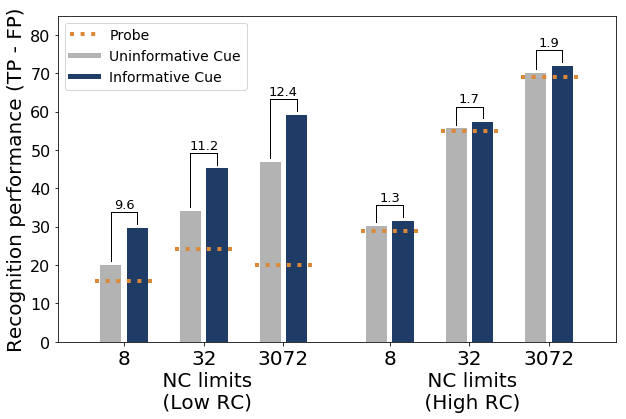

In [12]:
# Plotting results from a particular set of runs (subject to variance of around 1.5 for each value)

figure(figsize=(10, 6))

abc1 = [1,2,4,5,7,8,11,12,14,15,17,18]
ac1_bar = [20.1,29.7,34.0,45.2,46.8,59.2,30.3,31.6,55.6,57.3,70.1,72.0]
ac1_line = [12.2,15.8,22.6,24.3,13.7,20.1,14.8,29.0,46.6,55.0,61.4,69.0]
bc = (96./255.,152./255.,39./255.)
ffc = (219./255.,136./255.,56./255.)
fbuc = (.7,.7,.7)
fbuc_e = fbuc
fbcc = (31./255.,60./255.,103./255.)
color1_bar = [fbuc,fbcc,fbuc,fbcc,fbuc,fbcc,fbuc,fbcc,fbuc,fbcc,fbuc,fbcc] 
color1_line = [bc,ffc,bc,ffc,bc,ffc,bc,ffc,bc,ffc,bc,ffc]
bar(abc1,ac1_bar,color=color1_bar,label='_nolegend_')
xticks([1.5,4.5,7.5,11.5,14.5,17.5],['8','32\n NC limits\n (Low RC)','3072','8','32\n NC limits\n (High RC)','3072'], fontsize=20)
yticks(fontsize=16)
ylim([0,85])
xlim([-1,20])
#plot([abc1[0]-0.575,abc1[1]+0.6],[ac1_line[0],ac1_line[0]],':',color=bc,linewidth=4,label='_nolegend_')
plot([abc1[0]-0.575,abc1[1]+0.6],[ac1_line[1],ac1_line[1]],':',color=ffc,linewidth=4,label='_nolegend_')
#plot([abc1[2]-0.575,abc1[3]+0.6],[ac1_line[2],ac1_line[2]],':',color=bc,linewidth=4,label='_nolegend_')
plot([abc1[2]-0.575,abc1[3]+0.6],[ac1_line[3],ac1_line[3]],':',color=ffc,linewidth=4,label='_nolegend_')
#plot([abc1[4]-0.575,abc1[5]+0.6],[ac1_line[4],ac1_line[4]],':',color=bc,linewidth=4,label='_nolegend_')
plot([abc1[4]-0.575,abc1[5]+0.6],[ac1_line[5],ac1_line[5]],':',color=ffc,linewidth=4,label='_nolegend_')
#plot([abc1[6]-0.575,abc1[7]+0.6],[ac1_line[6],ac1_line[6]],':',color=bc,linewidth=4,label='_nolegend_')
plot([abc1[6]-0.575,abc1[7]+0.6],[ac1_line[7],ac1_line[7]],':',color=ffc,linewidth=4,label='_nolegend_')
#plot([abc1[8]-0.575,abc1[9]+0.6],[ac1_line[8],ac1_line[8]],':',color=bc,linewidth=4,label='_nolegend_')
plot([abc1[8]-0.575,abc1[9]+0.6],[ac1_line[9],ac1_line[9]],':',color=ffc,linewidth=4,label='_nolegend_')
#plot([abc1[10]-0.575,abc1[11]+0.6],[ac1_line[10],ac1_line[10]],':',color=bc,linewidth=4,label='_nolegend_')
plot([abc1[10]-0.575,abc1[11]+0.6],[ac1_line[11],ac1_line[11]],':',color=ffc,linewidth=4,label='_nolegend_')
#plot(abc1,-10+np.zeros([np.shape(abc1)[0],1]),':',color=bc,linewidth=4)
plot(abc1,-10+np.zeros([np.shape(abc1)[0],1]),':',color=ffc,linewidth=4)
plot(abc1,-10+np.zeros([np.shape(abc1)[0],1]),color=fbuc,linewidth=5)
plot(abc1,-10+np.zeros([np.shape(abc1)[0],1]),color=fbcc,linewidth=5)
bar(0,-1,color='w',hatch="o")
legend(['Probe','Uninformative Cue','Informative Cue'], fontsize=14)
ylabel('Recognition performance (TP - FP)',fontsize=20)

off_h = 1
plot([abc1[0], abc1[0]], [ac1_bar[0]+off_h, ac1_bar[1]+off_h+3], 'k-', lw=1)
plot([abc1[1], abc1[1]], [ac1_bar[1]+off_h, ac1_bar[1]+off_h+3], 'k-', lw=1)
plot([abc1[0], abc1[1]], [ac1_bar[1]+off_h+3, ac1_bar[1]+off_h+3], 'k-', lw=1)
text((abc1[0]+abc1[1])*1./2.,ac1_bar[1]+off_h+4,str(ac1_bar[1]-ac1_bar[0]),horizontalalignment='center',fontsize='13')
plot([abc1[2], abc1[2]], [ac1_bar[2]+off_h, ac1_bar[3]+off_h+3], 'k-', lw=1)
plot([abc1[3], abc1[3]], [ac1_bar[3]+off_h, ac1_bar[3]+off_h+3], 'k-', lw=1)
plot([abc1[2], abc1[3]], [ac1_bar[3]+off_h+3, ac1_bar[3]+off_h+3], 'k-', lw=1)
text((abc1[2]+abc1[3])*1./2.,ac1_bar[3]+off_h+4,str(ac1_bar[3]-ac1_bar[2]),horizontalalignment='center',fontsize='13')
plot([abc1[4], abc1[4]], [ac1_bar[4]+off_h, ac1_bar[5]+off_h+3], 'k-', lw=1)
plot([abc1[5], abc1[5]], [ac1_bar[5]+off_h, ac1_bar[5]+off_h+3], 'k-', lw=1)
plot([abc1[4], abc1[5]], [ac1_bar[5]+off_h+3, ac1_bar[5]+off_h+3], 'k-', lw=1)
text((abc1[4]+abc1[5])*1./2.,ac1_bar[5]+off_h+4,str(ac1_bar[5]-ac1_bar[4]),horizontalalignment='center',fontsize='13')
plot([abc1[6], abc1[6]], [ac1_bar[6]+off_h, ac1_bar[7]+off_h+3], 'k-', lw=1)
plot([abc1[7], abc1[7]], [ac1_bar[7]+off_h, ac1_bar[7]+off_h+3], 'k-', lw=1)
plot([abc1[6], abc1[7]], [ac1_bar[7]+off_h+3, ac1_bar[7]+off_h+3], 'k-', lw=1)
text((abc1[6]+abc1[7])*1./2.,ac1_bar[7]+off_h+4,str(ac1_bar[7]-ac1_bar[6]),horizontalalignment='center',fontsize='13')
plot([abc1[8], abc1[8]], [ac1_bar[8]+off_h, ac1_bar[9]+off_h+3], 'k-', lw=1)
plot([abc1[9], abc1[9]], [ac1_bar[9]+off_h, ac1_bar[9]+off_h+3], 'k-', lw=1)
plot([abc1[8], abc1[9]], [ac1_bar[9]+off_h+3, ac1_bar[9]+off_h+3], 'k-', lw=1)
text((abc1[8]+abc1[9])*1./2.,ac1_bar[9]+off_h+4,str(ac1_bar[9]-ac1_bar[8]),horizontalalignment='center',fontsize='13')
plot([abc1[10], abc1[10]], [ac1_bar[10]+off_h, ac1_bar[11]+off_h+3], 'k-', lw=1)
plot([abc1[11], abc1[11]], [ac1_bar[11]+off_h, ac1_bar[11]+off_h+3], 'k-', lw=1)
plot([abc1[10], abc1[11]], [ac1_bar[11]+off_h+3, ac1_bar[11]+off_h+3], 'k-', lw=1)
text((abc1[10]+abc1[11])*1./2.,ac1_bar[11]+off_h+4,str(ac1_bar[11]-ac1_bar[10]),horizontalalignment='center',fontsize='13')